   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
%pip install pysindy
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import warnings
from pysindy.utils.axes import AxesWarning
warnings.filterwarnings("ignore", category=AxesWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.4 MB/s eta 0:00:00


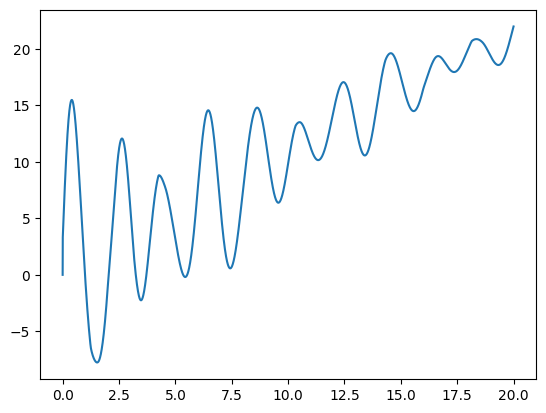

In [ ]:
# 3D Voce + Perzyna (small-strain J2) + SINDy on invariants
# ----------------------------------------------------------
# Voigt order: [xx, yy, zz, yz, xz, xy] with engineering shear.
# SINDy learns epbar_dot from scalar invariants: [overstress, epbar, eq_total_strain_rate].

import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

# ========= Material =========
E      = 2000.0          # Young's modulus
nu     = 0.30            # Poisson's ratio
sigy0  = 5.0             # initial yield stress
Q, b   = 12.0, 40.0      # Voce: sig_y = sigy0 + Q*(1 - exp(-b*epbar))
eta_vp = 20.0            # Perzyna viscosity
m_vp   = 1.0             # Perzyna exponent (1 = linear)

# ========= Voigt algebra helpers (engineering shear) =========
# Double-dot metric for engineering shear:
# a:b = a0*b0 + a1*b1 + a2*b2 + 0.5*(a3*b3 + a4*b4 + a5*b5)
_WDOT = np.array([1, 1, 1, 0.5, 0.5, 0.5], dtype=float)

def ddot6(a, b):
    """Double-dot product in 6x1 Voigt with engineering shear."""
    return float(np.sum(_WDOT * a * b))

def lame_parameters(E, nu):
    lam = E*nu/((1+nu)*(1-2*nu))
    mu  = E/(2*(1+nu))
    return lam, mu

def C_iso_6x6(E, nu):
    """Isotropic elasticity (6x6) for engineering shear."""
    lam, mu = lame_parameters(E, nu)
    C = np.zeros((6, 6), dtype=float)
    C[0:3, 0:3] = lam
    np.fill_diagonal(C[0:3, 0:3], lam + 2*mu)
    C[3, 3] = 2*mu; C[4, 4] = 2*mu; C[5, 5] = 2*mu
    return C

def deviator_6(sig6):
    """Deviatoric part of a 6-vector (subtract mean normal from normal comps)."""
    s = sig6.copy()
    p = np.mean(s[0:3])
    s[0:3] -= p
    return s

def von_mises(sig6):
    """Von Mises equivalent stress and deviator s, engineering shear metric."""
    s = deviator_6(sig6)
    seq = np.sqrt(1.5 * ddot6(s, s))
    return seq, s

def eq_strain_rate(epsdot6):
    """Von Mises equivalent total strain rate (uses deviatoric part)."""
    e = epsdot6.copy()
    e[0:3] -= np.mean(e[0:3])
    return np.sqrt(2.0/3.0 * ddot6(e, e))

# ========= Material model simulator
# Input strain, time step, stiffness and poisson ration =========
def simulate_3d(eps_hist, dt, E=E, nu=nu):
    """
    eps_hist: (N,6) total strain history in Voigt (engineering shear)
    dt:       time step
    Returns:  sig(N,6), ep(N,6), epbar(N,), sig_y(N,), f(N,)
    """
    N  = eps_hist.shape[0]
    C  = C_iso_6x6(E, nu)
    ep = np.zeros((N, 6))
    epbar = np.zeros(N)
    sig = np.zeros((N, 6))
    sig_y = np.zeros(N)
    f = np.zeros(N)

    tiny = 1e-16
    for k in range(1, N):
        # Elastic predictor from previous step state
        sig_tr = C @ (eps_hist[k-1] - ep[k-1])
        seq, s = von_mises(sig_tr)

        # Isotropic Voce hardening from accumulated plastic strain
        sigy_km1 = sigy0 + Q * (1.0 - np.exp(-b * epbar[k-1]))
        sig_y[k-1] = sigy_km1
        f[k-1] = seq - sigy_km1

        # Perzyna viscoplastic flow if overstress > 0
        if f[k-1] > 0.0 and seq > tiny:
            # For associative J2: epbar_dot equals the plastic multiplier lambda_dot
            epbar_dot = (f[k-1] / eta_vp) ** m_vp
            n = s / seq                                    # flow direction
            dep = 1.5 * epbar_dot * n                      # dep = (3/2) * epbar_dot * n
            ep[k]    = ep[k-1] + dt * dep
            epbar[k] = epbar[k-1] + dt * epbar_dot
        else:
            ep[k]    = ep[k-1]
            epbar[k] = epbar[k-1]

        # Stress update with corrected plastic strain at time k
        sig[k] = C @ (eps_hist[k] - ep[k])

    # Last-step bookkeeping
    seq_last, _ = von_mises(C @ (eps_hist[-1] - ep[-1]))
    sig_y[-1] = sigy0 + Q * (1.0 - np.exp(-b * epbar[-1]))
    f[-1] = seq_last - sig_y[-1]
    return sig, ep, epbar, sig_y, f

# ========= Synthetic multiaxial paths (train/validate) =========
def make_path(t, seed=0):
    """Smooth multiaxial history with shear; small volumetric drift."""
    rng = np.random.default_rng(seed)
    s = lambda A, f, d, a: A*np.sin(2*np.pi*f*t + d)*np.exp(-a*t)
    exx = s(0.004, 0.50, 0.0, 0.10) + 0.0004*t
    eyy = s(0.003, 0.35, 0.7, 0.07) + 0.0001*t
    ezz = s(0.002, 0.80, 0.3, 0.20)
    gyz = s(0.003, 0.40, 0.5, 0.12)
    gxz = s(0.002, 0.60, 1.2, 0.15)
    gxy = s(0.002, 0.30, 0.9, 0.08)
    base = np.vstack([exx, eyy, ezz, gyz, gxz, gxy]).T
    # slight random scaling per component
    scale = (1.0 + 0.05*rng.standard_normal(6)).astype(float)
    return base * scale

# Time grid
dt = 1e-3
t  = np.arange(0.0, 20.0, dt)

# Histories
eps_tr = make_path(t, seed=1)
eps_va = make_path(t, seed=2)

# Ground-truth responses
sig_tr, ep_tr, epbar_tr, sigy_tr, f_tr = simulate_3d(eps_tr, dt)
sig_va, ep_va, epbar_va, sigy_va, f_va = simulate_3d(eps_va, dt)

# ========= Plots =========
plt.figure
plt.plot(t,sig_tr[:,0], label=r"$\sigma_{xx}$")



Plastic fraction (train): 0.154


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/sr3.py:374: ConvergenceWarning: SR3 did not converge after 10000 iterations.
  warnings.warn(



=== Coefficients (scaled) ===
+2.170080e+01  *  over           
-2.486951e+01  *  epbar          
+0.000000e+00  *  eqeps_dot      
-9.340707e+00  *  over^2         
+2.134624e+01  *  over epbar     
+1.126770e+00  *  over eqeps_dot 
-9.148850e+00  *  epbar^2        
-1.111828e+00  *  epbar eqeps_dot
-0.000000e+00  *  eqeps_dot^2    

Intercept (unscaled): +1.932100e-04
Top terms (|coef|, unscaled):
-1.353698e+03  *  epbar^2
-2.968674e+02  *  epbar eqeps_dot
-2.205173e+01  *  epbar
+7.335165e+00  *  over epbar
+6.393499e-01  *  over eqeps_dot
+4.591182e-02  *  over
-7.463233e-03  *  over^2

Validation RMSE  ||σ||: 4.0448e-04   seq: 1.0012e-03   ||ep||: 2.6291e-07   epbar: 1.3994e-06


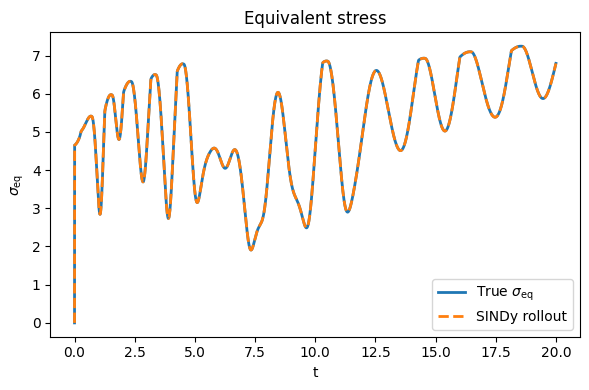

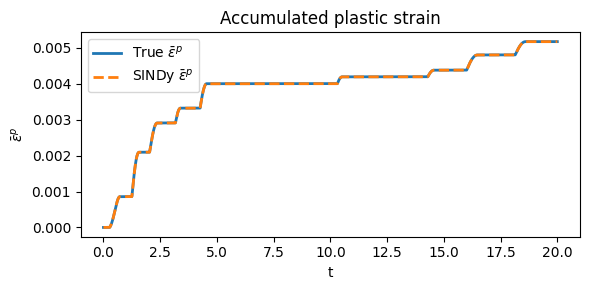

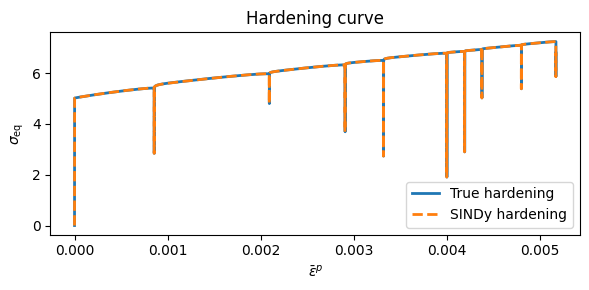

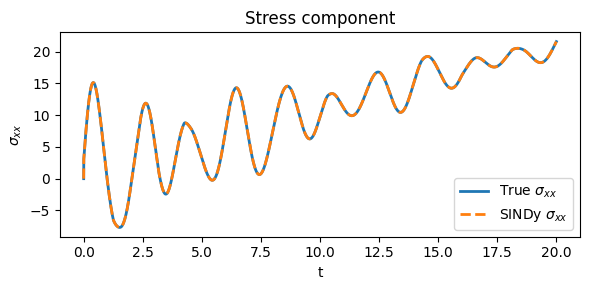

In [ ]:

# ========= Invariants for learning =========
# Equivalent stress
seq_tr = np.array([von_mises(sig_tr[k])[0] for k in range(len(t))])
seq_va = np.array([von_mises(sig_va[k])[0] for k in range(len(t))])

# Estimate initial yield from first plastic activation on TRAIN
onset_idx = np.argmax(epbar_tr > 0)
sigy0_hat = seq_tr[onset_idx] if onset_idx > 0 else sigy0

# Overstress (data-driven)
over_tr = seq_tr - sigy0_hat
over_va = seq_va - sigy0_hat

# Total strain-rate invariants
epsdot_tr = np.gradient(eps_tr, dt, axis=0)
epsdot_va = np.gradient(eps_va, dt, axis=0)
eqepsdot_tr = np.array([eq_strain_rate(epsdot_tr[k]) for k in range(len(t))])
eqepsdot_va = np.array([eq_strain_rate(epsdot_va[k]) for k in range(len(t))])

# Target: equivalent plastic strain rate
epbardot_tr = np.gradient(epbar_tr, dt)
epbardot_va = np.gradient(epbar_va, dt)

# Plastic-only mask for TRAIN
mask_pl = epbardot_tr > 1e-12
print(f"Plastic fraction (train): {mask_pl.mean():.3f}")

# ========= Design matrix Θ (polynomial features) =========
# Base features: X = [over, epbar, eqeps_dot]
X_tr = np.column_stack([over_tr, epbar_tr, eqepsdot_tr])[mask_pl]
y_tr = epbardot_tr[mask_pl]

names = ["over", "epbar", "eqeps_dot"]

# Degree-2 with interactions (expand if needed)
poly = ps.PolynomialLibrary(degree=2, include_bias=False, include_interaction=True)
Phi_raw  = poly.fit_transform(X_tr)
phi_names = poly.get_feature_names(input_features=names)

# Z-score Θ and y (fit on TRAIN-plastic)
Xmu  = Phi_raw.mean(0);  Xstd = Phi_raw.std(0) + 1e-12
ymu  = y_tr.mean();      ystd = y_tr.std()    + 1e-12
Phi  = (Phi_raw - Xmu)/Xstd
y    = (y_tr   - ymu)/ystd

##################   SINDY STARTS HERE   #############################
# ========= Sparse regression (SINDy) =========
######################################################################

lib = ps.IdentityLibrary()
opt = ps.SR3(reg_weight_lam=0.10, relax_coeff_nu=1.00, max_iter=10000, tol=1e-12)
model = ps.SINDy(feature_library=lib, optimizer=opt)
model.feature_names = phi_names
model.state_names   = ["epbar"]
model.fit(Phi, t=dt, x_dot=y)

# Coefficients (scaled and unscaled)
coefs_s = np.ravel(model.coefficients()[0])            # scaled weights
w_unscaled = (ystd / Xstd) * coefs_s                   # map back to raw features
b_unscaled = ymu - float(np.dot(w_unscaled, Xmu))      # intercept

# Report
w_len = max(12, max(len(n) for n in phi_names))
print("\n=== Coefficients (scaled) ===")
for c, n in zip(coefs_s, phi_names):
    print(f"{c:+12.6e}  *  {n:<{w_len}}")
print("\nIntercept (unscaled):", f"{b_unscaled:+.6e}")
print("Top terms (|coef|, unscaled):")
order = np.argsort(-np.abs(w_unscaled))
for j in order[:10]:
    if abs(w_unscaled[j]) > 0:
        print(f"{w_unscaled[j]:+.6e}  *  {phi_names[j]}")

# ========= Fast RHS (no model.predict) =========
def epbardot_fast(over, epbar, eqepsdot):
    """
    epbar_dot = g(over, epbar, eqepsdot) >= 0
    Enforce non-negativity by clipping (physical constraint).
    """
    Phi_row = poly.transform(np.array([[over, epbar, eqepsdot]]) )[0]
    g = float(b_unscaled + np.dot(w_unscaled, Phi_row))
    return max(0.0, g)

# ========= Rollout on validation =========
def rollout_epbar(eps_hist, dt, E=E, nu=nu):
    """Integrate epbar via learned RHS and reconstruct tensorial ep by associative flow."""
    N = eps_hist.shape[0]
    C = C_iso_6x6(E, nu)
    sig = np.zeros((N, 6))
    ep  = np.zeros((N, 6))
    epbar = np.zeros(N)
    epsdot = np.gradient(eps_hist, dt, axis=0)
    tiny = 1e-16

    for k in range(1, N):
        # Elastic trial from previous state
        sig_tr = C @ (eps_hist[k-1] - ep[k-1])
        seq, s = von_mises(sig_tr)
        over   = seq - sigy0_hat
        eqdot  = eq_strain_rate(epsdot[k-1])

        # Learned equivalent plastic strain rate
        gk = epbardot_fast(over, epbar[k-1], eqdot)

        # Convert scalar rate to tensorial plastic flow: dep = (3/2)*gk*n
        if gk > 0.0 and seq > tiny:
            n = s / seq
            dep = 1.5 * gk * n
            ep[k]    = ep[k-1] + dt * dep
            epbar[k] = epbar[k-1] + dt * gk
        else:
            ep[k]    = ep[k-1]
            epbar[k] = epbar[k-1]

        # Stress update at k
        sig[k] = C @ (eps_hist[k] - ep[k])

    return sig, ep, epbar

sig_hat, ep_hat, epbar_hat = rollout_epbar(eps_va, dt)

# ========= Metrics =========
def vm_seq(sig_arr):
    return np.array([von_mises(s)[0] for s in sig_arr])

seq_true = vm_seq(sig_va)
seq_pred = vm_seq(sig_hat)

rmse_sig = np.sqrt(np.mean((sig_hat - sig_va)**2))                 # Frobenius in Voigt metric
rmse_seq = np.sqrt(np.mean((seq_pred - seq_true)**2))
rmse_ep  = np.sqrt(np.mean((ep_hat  - ep_va )**2))
rmse_epb = np.sqrt(np.mean((epbar_hat - epbar_va)**2))
print(f"\nValidation RMSE  ||σ||: {rmse_sig:.4e}   seq: {rmse_seq:.4e}   ||ep||: {rmse_ep:.4e}   epbar: {rmse_epb:.4e}")

# ========= Plots =========
plt.figure(figsize=(6,4))
plt.plot(t, seq_true,  lw=2, label=r"True $\sigma_{\rm eq}$")
plt.plot(t, seq_pred, "--", lw=2, label=r"SINDy rollout")
plt.xlabel("t"); plt.ylabel(r"$\sigma_{\rm eq}$"); plt.title("Equivalent stress"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(t, epbar_va,  lw=2, label=r"True $\bar\varepsilon^p$")
plt.plot(t, epbar_hat, "--", lw=2, label=r"SINDy $\bar\varepsilon^p$")
plt.xlabel("t"); plt.ylabel(r"$\bar\varepsilon^p$"); plt.title("Accumulated plastic strain"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(epbar_va, seq_true,  lw=2, label="True hardening")
plt.plot(epbar_hat, seq_pred, "--", lw=2, label="SINDy hardening")
plt.xlabel(r"$\bar\varepsilon^p$"); plt.ylabel(r"$\sigma_{\rm eq}$"); plt.title("Hardening curve"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(t, sig_va[:,0],  lw=2, label=r"True $\sigma_{xx}$")
plt.plot(t, sig_hat[:,0], "--", lw=2, label=r"SINDy $\sigma_{xx}$")
plt.xlabel("t"); plt.ylabel(r"$\sigma_{xx}$"); plt.title("Stress component"); plt.legend(); plt.tight_layout(); plt.show()
